<a href="https://colab.research.google.com/github/Sevi9/colab/blob/main/%E2%80%9Cdeeplearning_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#第一部分配置环境
from google.colab import drive
drive.mount('/content/drive')
import os
path = "/content/drive/MyDrive" 
os.chdir(path)
!ls


Mounted at /content/drive
'Colab Notebooks'   d2l-zh   d2l-zh.zip   mxnet   paddle   pytorch   tensorflow


In [ ]:
#第二部分下载资源
!mkdir d2l-zh && cd d2l-zh
!curl https://zh-v2.d2l.ai/d2l-zh.zip -o d2l-zh.zip
!unzip d2l-zh.zip && rm d2l-zh.zip
!pip install mxnet-cu101==1.7.0
!pip install -U d2l


In [ ]:
#第三部分进入文件夹下开始动手
import os
path = "/content/drive/MyDrive/d2l-zh" 
os.chdir(path)
import mxnet


In [ ]:
!pip install -U d2l

In [ ]:
!pip install matplotlib_inline


In [ ]:
!pip install matplotlib==3.0.0

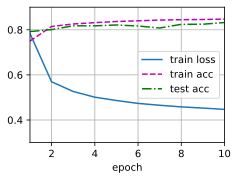

In [7]:
#softmax回归的简洁实现
%matplotlib inline
import torch
from torch import nn
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from IPython import display
batch_size=256
num_inputs = 784
num_outputs = 10
w = torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)

train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
#pytorch不会隐式地调整输入的形状，因此要定义展平层（flatten）在线性层前调整网络输入的形状
net=nn.Sequential(nn.Flatten(),nn.Linear(784,10))#flatten将任何维度的tensor变成2d的tensor，第0维度保留，剩下全部展成一个向量
def accuracy(y_hat,y):
  """计算预测正确的数量"""
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: # y_hat.shape[1]>1表示不止一个类别，每个类别有各自的概率   
    y_hat = y_hat.argmax(axis=1) # y_hat.argmax(axis=1)为求行最大值的索引
  cmp = y_hat.type(y.dtype) == y # 先判断逻辑运算符==，再赋值给cmp，cmp为布尔类型的数据
  return float(cmp.type(y.dtype).sum()) # 获得y.dtype的类型作为传入参数，将cmp的类型转为y的类型（int型），然后再求和   
# 可以评估在任意模型net的准确率
def evaluate_accuracy(net,data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net,torch.nn.Module): # 如果net模型是torch.nn.Module实现的神经网络的话，将它变成评估模式     
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数，metric为累加器的实例化对象，里面存了两个数
    for X, y in data_iter:
        metric.add(accuracy(net(X),y),y.numel()) # net(X)将X输入模型，获得预测值。y.numel()为样本总数
    return metric[0] / metric[1] # 分类正确的样本数 / 总样本数
# 训练函数
def train_epoch_ch3(net, train_iter, loss, updater):
  if isinstance(net, torch.nn.Module):
    net.train() # 开启训练模式
  metric = Accumulator(3)
  for X, y in train_iter:
    y_hat = net(X)
    l = loss(y_hat,y) # 计算损失
    if isinstance(updater,torch.optim.Optimizer): # 如果updater是pytorch的优化器的话
      updater.zero_grad()
      l.mean().backward()  # 这里对loss取了平均值出来
      updater.step()
      metric.add(float(l)*len(y),accuracy(y_hat,y),y.size().numel()) # 总的训练损失、样本正确数、样本总数   
    else:
      l.sum().backward()
      updater(X.shape[0])
      metric.add(float(l.sum()),accuracy(y_hat,y),y.numel()) 
  return metric[0] / metric[2], metric[1] / metric[2] # 所有loss累加除以样本总数，总的正确个数除以样本总数  
class Accumulator:
  """在n个变量上累加"""
  def __init__(self,n):
    self.data = [0,0] * n
  def add(self, *args):
    self.data = [a+float(b) for a,b in zip(self.data,args)] # zip函数把两个列表第一个位置元素打包、第二个位置元素打包....
        
  def reset(self):
    self.data = [0.0] * len(self.data)
        
  def __getitem__(self,idx):
    return self.data[idx]
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear',yscale='linear',
                fmts=('-','m--','g-.','r:'),nrows=1,ncols=1,
                figsize=(3.5,2.5)): 
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows,ncols,figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: d2l.set_axes(self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend)         
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)] 
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
# 总训练函数        
def train_ch3(net,train_iter,test_iter,loss,num_epochs,updater):
  animator = Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0.3,0.9],       
                       legend=['train loss','train acc','test acc'])
  for epoch in range(num_epochs):  # 变量num_epochs遍数据
   train_metrics = train_epoch_ch3(net,train_iter,loss,updater) # 返回两个值，一个总损失、一个总正确率
   test_acc = evaluate_accuracy(net,test_iter) # 测试数据集上评估精度，仅返回一个值，总正确率  
   animator.add(epoch+1,train_metrics+(test_acc,)) # train_metrics+(test_acc,) 仅将两个值的正确率相加，
   train_loss, train_acc = train_metrics  
def init_weights(m):#m为当前layer
  if type(m)==nn.Linear:
    nn.init.normal_(m.weight,std=0.01)#weight初始化为均值为0，标准差为0.01的随机值
net.apply(init_weights)#函数应用到net的每一层中完成初始化
loss=nn.CrossEntropyLoss(reduction="none")
trainer=torch.optim.SGD(net.parameters(),lr=0.1)#使用学习率为0.1的小批量随机梯度下降作为优化算法
#调用之前定义的训练函数来训练模型
num_epochs=10
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)


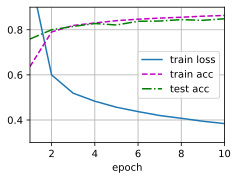

In [6]:
#多层感知机从零开始实现
import torch
from torch import nn
from d2l import torch as d2l
batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
#实现一个单隐藏层的多层感知机，包含256个隐藏单元
num_inputs,num_outputs,num_hiddens=784,10,256
w1=nn.Parameter(torch.randn(num_inputs,num_hiddens,requires_grad=True)*0.01)#随机行数为784，列数为256，×0.01为了把方差变为0.01
b1=nn.Parameter(torch.zeros(num_hiddens,requires_grad=True))#normal和randn区别在于normal可以自己设定方差而randn只是生成
w2=nn.Parameter(torch.randn(num_hiddens,num_outputs,requires_grad=True)*0.01)
b2=nn.Parameter(torch.zeros(num_outputs,requires_grad=True))
params=[w1,b1,w2,b2]
#实现ReLU激活函数
def relu(x):
  a=torch.zeros_like(x)#与x形状一样但元素均为0
  return torch.max(x,a)
#实现模型
def net(x):
  x=x.reshape((-1,num_inputs))#x为batchsize*784
  h=relu(x@w1+b1)#@是矩阵相乘
  return (h@w2+b2)
loss=nn.CrossEntropyLoss(reduction="none")
#训练——多层感知机训练过程同softmax回归训练过程
num_epochs,lr=10,0.1
updater=torch.optim.SGD(params,lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,updater)
#可对比上一张图的loss下降，精度没有改变太多，模型更大，数据拟合性更好，损失下降

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.0.0

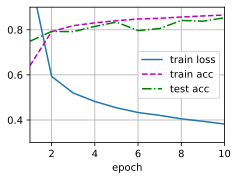

In [5]:
#多层感知机的简洁实现
import torch
from torch import nn
from d2l import torch as d2l
net = nn.Sequential(nn.Flatten(),nn.Linear(784,256),
                    nn.ReLU(),
                    nn.Linear(256,10))

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)